In [1]:
import sys

PWD = '..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample
from src.cfd import CFD
from src.cfd_utils import TIME_STEP

In [2]:
dataset = np.load(f'../data/dataset.npz', allow_pickle=True)

In [3]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19570, 64), (19570,))

# Preprocess

In [4]:
n_baseline = 20

In [5]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42, shuffle=False)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

# Utils

In [7]:
def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val loss ({history[f'val_loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()
    
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')

# CFD

In [8]:
cfd = CFD(fraction=0.14)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3914,)

In [9]:
mean_squared_error(y_test, y_pred)

0.24676905424039672

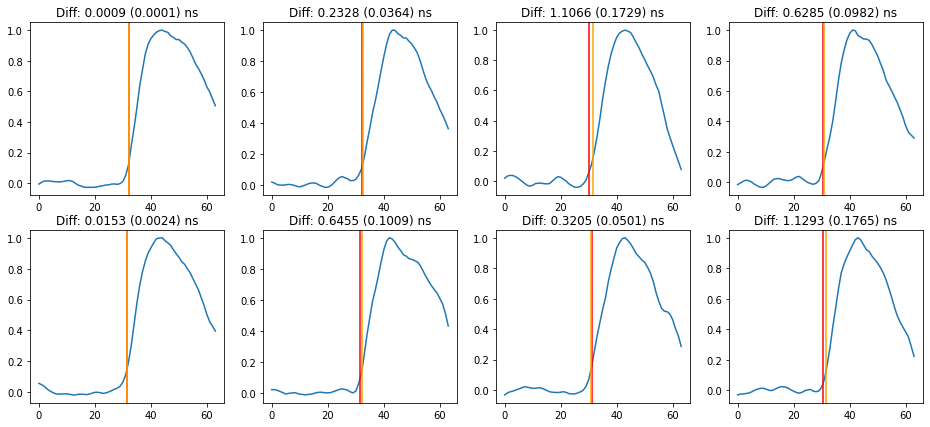

In [10]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

# Model 1

In [11]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.1))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40))

history = model.fit(X_train, y_train, epochs=2000, verbose=1, batch_size=1024, validation_data=(X_test, y_test), callbacks=model_callbacks)

Epoch 1/2000
16/16 [==============================] - 1s 9ms/step - loss: 350.6695 - val_loss: 4.2652 - lr: 0.1000
Epoch 2/2000
16/16 [==============================] - 0s 4ms/step - loss: 33.6700 - val_loss: 21.3576 - lr: 0.1000
Epoch 3/2000
16/16 [==============================] - 0s 4ms/step - loss: 8.0328 - val_loss: 8.5277 - lr: 0.1000
Epoch 4/2000
16/16 [==============================] - 0s 4ms/step - loss: 5.1175 - val_loss: 3.3901 - lr: 0.1000
Epoch 5/2000
16/16 [==============================] - 0s 4ms/step - loss: 3.3953 - val_loss: 3.1821 - lr: 0.1000
Epoch 6/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.9930 - val_loss: 3.0963 - lr: 0.1000
Epoch 7/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.8208 - val_loss: 2.9087 - lr: 0.1000
Epoch 8/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.6889 - val_loss: 2.7976 - lr: 0.1000
Epoch 9/2000
16/16 [==============================] - 0s 3ms/step - loss: 2.5654 - val_loss:

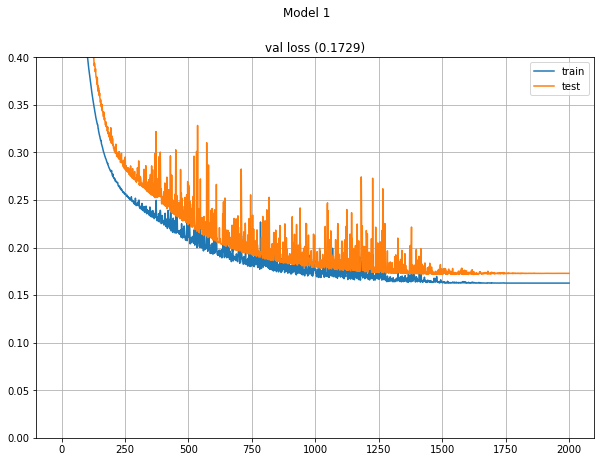

In [12]:
plot_history(history.history, "Model 1", ymax=0.4)

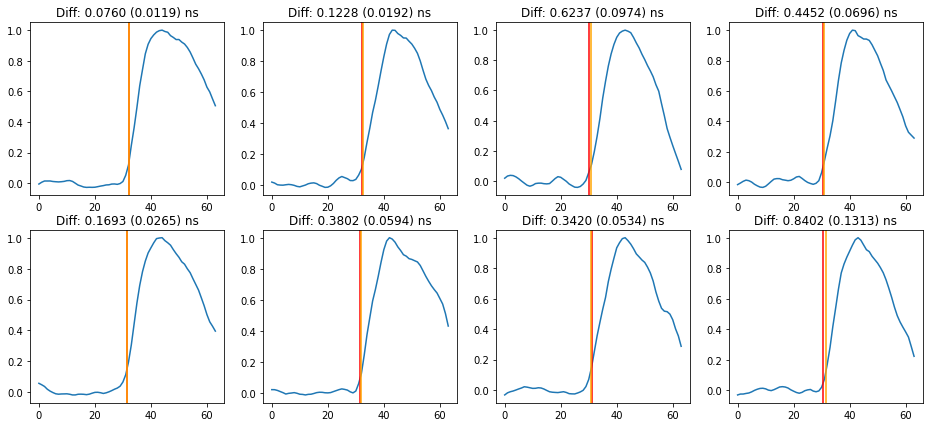

In [13]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

# Model 2

In [14]:
model = keras.Sequential([
    layers.Input(64),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.005))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40))

history = model.fit(X_train, y_train, epochs=2000, verbose=1, batch_size=1024, validation_data=(X_test, y_test), callbacks=model_callbacks)

Epoch 1/2000
16/16 [==============================] - 0s 9ms/step - loss: 762.4636 - val_loss: 196.1739 - lr: 0.0050
Epoch 2/2000
16/16 [==============================] - 0s 4ms/step - loss: 69.4984 - val_loss: 5.9624 - lr: 0.0050
Epoch 3/2000
16/16 [==============================] - 0s 4ms/step - loss: 17.8802 - val_loss: 5.9492 - lr: 0.0050
Epoch 4/2000
16/16 [==============================] - 0s 4ms/step - loss: 6.0544 - val_loss: 5.3969 - lr: 0.0050
Epoch 5/2000
16/16 [==============================] - 0s 4ms/step - loss: 3.1797 - val_loss: 2.5429 - lr: 0.0050
Epoch 6/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.4248 - val_loss: 2.4510 - lr: 0.0050
Epoch 7/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.2909 - val_loss: 2.3819 - lr: 0.0050
Epoch 8/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.1804 - val_loss: 2.2836 - lr: 0.0050
Epoch 9/2000
16/16 [==============================] - 0s 4ms/step - loss: 2.0910 - val_los

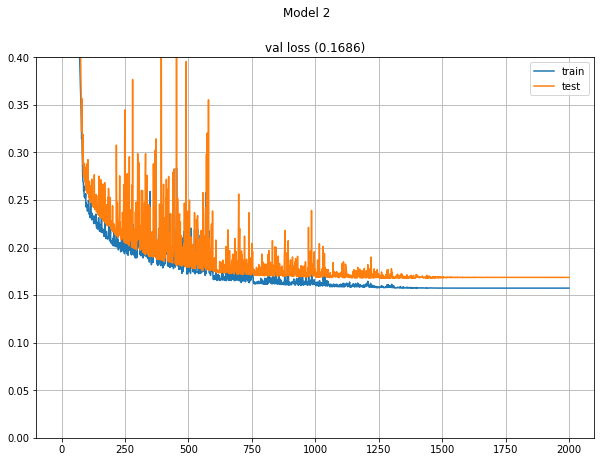

In [15]:
plot_history(history.history, "Model 2", ymax=0.4)

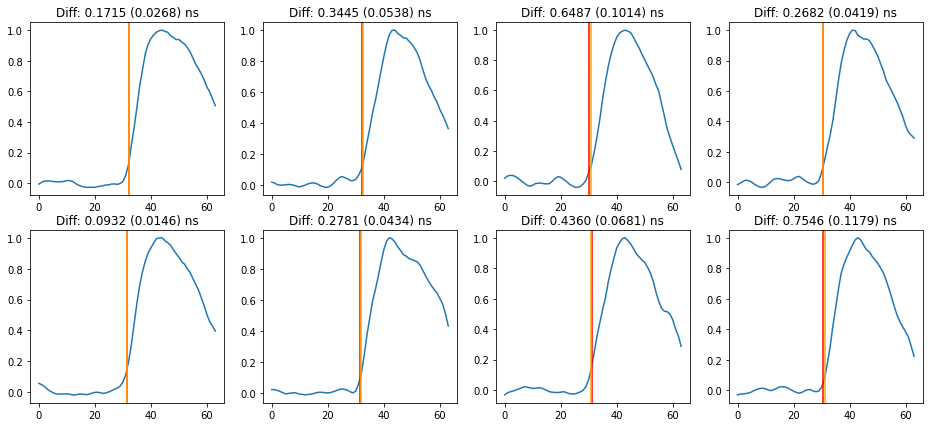

In [16]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

# Model 3

In [20]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
#     layers.Conv1D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling1D(2),
    
#     layers.Conv1D(256, 3, padding='same', activation='relu'),
#     layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.002))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40))

history = model.fit(X_train, y_train, epochs=1500, verbose=1, batch_size=1024, validation_data=(X_test, y_test), callbacks=model_callbacks)

Epoch 1/1500
16/16 [==============================] - 1s 13ms/step - loss: 937.1124 - val_loss: 736.2753 - lr: 0.0020
Epoch 2/1500
16/16 [==============================] - 0s 8ms/step - loss: 351.1024 - val_loss: 15.0179 - lr: 0.0020
Epoch 3/1500
16/16 [==============================] - 0s 8ms/step - loss: 37.9154 - val_loss: 14.2360 - lr: 0.0020
Epoch 4/1500
16/16 [==============================] - 0s 8ms/step - loss: 9.6244 - val_loss: 3.4360 - lr: 0.0020
Epoch 5/1500
16/16 [==============================] - 0s 8ms/step - loss: 2.6495 - val_loss: 2.1128 - lr: 0.0020
Epoch 6/1500
16/16 [==============================] - 0s 8ms/step - loss: 1.3757 - val_loss: 1.2229 - lr: 0.0020
Epoch 7/1500
16/16 [==============================] - 0s 8ms/step - loss: 1.1171 - val_loss: 1.1344 - lr: 0.0020
Epoch 8/1500
16/16 [==============================] - 0s 8ms/step - loss: 1.0598 - val_loss: 1.0932 - lr: 0.0020
Epoch 9/1500
16/16 [==============================] - 0s 9ms/step - loss: 1.0415 - val

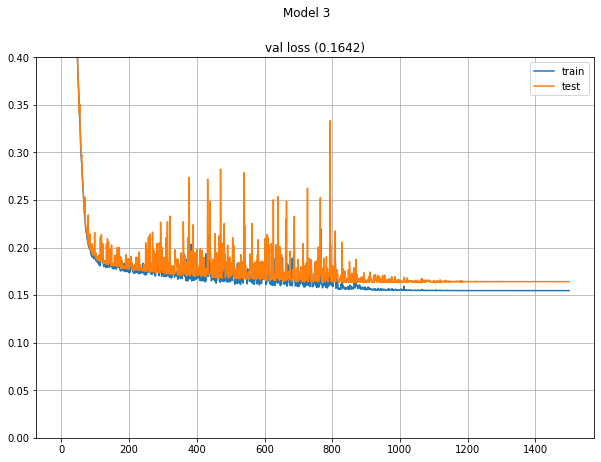

In [21]:
plot_history(history.history, "Model 3", ymax=0.4)

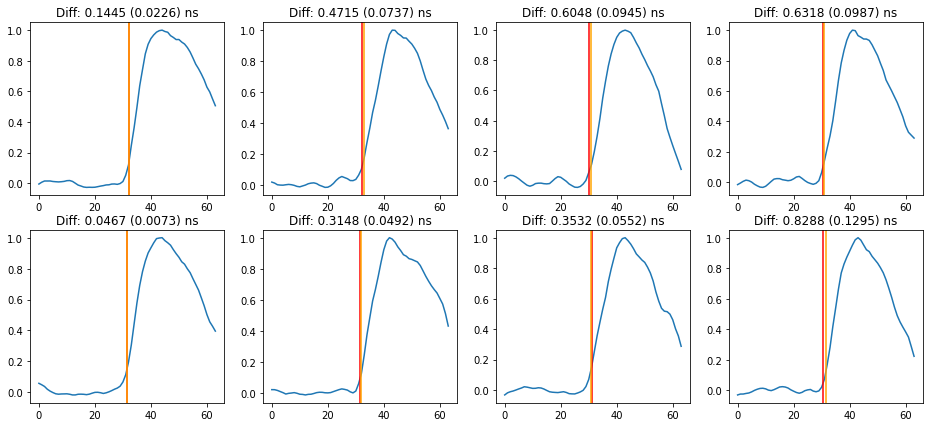

In [22]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)